In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

pd.set_option('display.max_columns', None)


In [49]:
df = pd.read_csv(r"C:\fili\jupyter_proyectos\articulos_ml.csv")
df.head()


,Title,url,Word count,# of Links,# of comments,# Images video,Elapsed days,# Shares
0,What is Machine Learning and how do we use it ...,https://blog.signals.network/what-is-machine-l...,1888,1,2.0,2,34,200000
1,10 Companies Using Machine Learning in Cool Ways,NaN,1742,9,NaN,9,5,25000
2,How Artificial Intelligence Is Revolutionizing...,NaN,962,6,0.0,1,10,42000
3,Dbrain and the Blockchain of Artificial Intell...,NaN,1221,3,NaN,2,68,200000
4,Nasa finds entire solar system filled with eig...,NaN,2039,1,104.0,4,131,200000


In [50]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           161 non-null    object 
 1   url             122 non-null    object 
 2   Word count      161 non-null    int64  
 3   # of Links      161 non-null    int64  
 4   # of comments   129 non-null    float64
 5   # Images video  161 non-null    int64  
 6   Elapsed days    161 non-null    int64  
 7   # Shares        161 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 10.2+ KB


Title              0
url               39
Word count         0
# of Links         0
# of comments     32
# Images video     0
Elapsed days       0
# Shares           0
dtype: int64

In [51]:
# Solo columnas numéricas
df_num = df.select_dtypes(include=[np.number]).copy()

df_num.info()
df_num.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Word count      161 non-null    int64  
 1   # of Links      161 non-null    int64  
 2   # of comments   129 non-null    float64
 3   # Images video  161 non-null    int64  
 4   Elapsed days    161 non-null    int64  
 5   # Shares        161 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 7.7 KB


Word count         0
# of Links         0
# of comments     32
# Images video     0
Elapsed days       0
# Shares           0
dtype: int64

In [52]:
# Nombre de la columna objetivo (ajusta si se llama diferente)
target_col = '# Shares'

# Eliminar filas donde la variable objetivo esté vacía
df_num = df_num.dropna(subset=[target_col])

# Columnas de características (todas menos el target)
feature_cols = [c for c in df_num.columns if c != target_col]

# Rellenar NaN en features con la mediana
df_num[feature_cols] = df_num[feature_cols].fillna(df_num[feature_cols].median())

print("NaN por columna después de imputar:")
print(df_num.isnull().sum())


NaN por columna después de imputar:
Word count        0
# of Links        0
# of comments     0
# Images video    0
Elapsed days      0
# Shares          0
dtype: int64


In [53]:
X = df_num[feature_cols]
y = df_num[target_col]

# Reset de índices por seguridad
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)


Shapes:
X_train: (128, 5)
y_train: (128,)
X_test : (33, 5)
y_test : (33,)


In [54]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled  shape:", X_test_scaled.shape)


X_train_scaled shape: (128, 5)
X_test_scaled  shape: (33, 5)


In [55]:
print("¿Hay NaN en X_train_scaled?:", np.isnan(X_train_scaled).any())
print("¿Hay NaN en y_train?:", y_train.isnull().any())


¿Hay NaN en X_train_scaled?: False
¿Hay NaN en y_train?: False


In [56]:
def evaluar_regresion(y_true, y_pred, titulo=""):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)   # sin squared
    rmse = np.sqrt(mse)                        # raíz cuadrada a mano
    r2   = r2_score(y_true, y_pred)
    
    print(f"=== {titulo} ===")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R2  : {r2:,.4f}")


In [57]:
ridge_base = Ridge()
ridge_base.fit(X_train_scaled, y_train)

y_train_pred_base = ridge_base.predict(X_train_scaled)
y_test_pred_base  = ridge_base.predict(X_test_scaled)

evaluar_regresion(y_train, y_train_pred_base, "Entrenamiento (Ridge base)")
evaluar_regresion(y_test,  y_test_pred_base,  "Prueba (Ridge base)")


=== Entrenamiento (Ridge base) ===
MAE : 26,015.38
RMSE: 40,375.51
R2  : 0.2754
=== Prueba (Ridge base) ===
MAE : 21,204.82
RMSE: 26,095.26
R2  : -0.7998


In [58]:
param_grid = {
    "alpha": [0.01, 0.1, 1, 10, 50, 100, 200]
}

ridge = Ridge()

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros:")
print(grid_search.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Mejores hiperparámetros:
{'alpha': 200}


In [59]:
best_ridge = grid_search.best_estimator_

y_train_pred_best = best_ridge.predict(X_train_scaled)
y_test_pred_best  = best_ridge.predict(X_test_scaled)

evaluar_regresion(y_train, y_train_pred_best, "Entrenamiento (Ridge optimizado)")
evaluar_regresion(y_test,  y_test_pred_best,  "Prueba (Ridge optimizado)")


=== Entrenamiento (Ridge optimizado) ===
MAE : 26,187.31
RMSE: 42,593.00
R2  : 0.1936
=== Prueba (Ridge optimizado) ===
MAE : 19,553.11
RMSE: 23,011.45
R2  : -0.3996


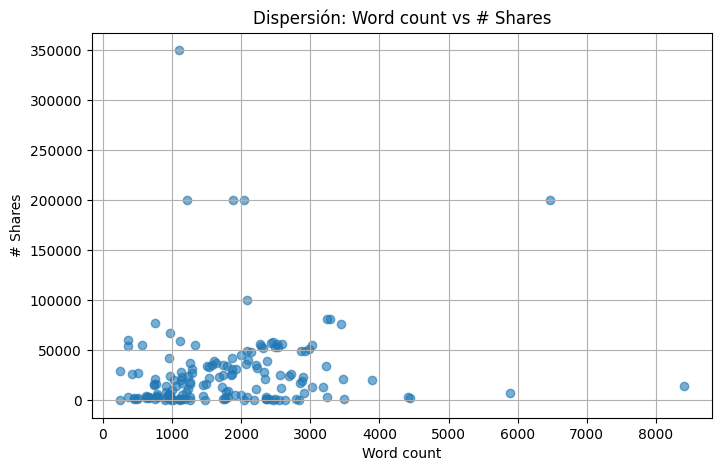

In [60]:
plt.figure(figsize=(8, 5))
plt.scatter(df['Word count'], df[target_col], alpha=0.6)
plt.xlabel("Word count")
plt.ylabel("# Shares")
plt.title("Dispersión: Word count vs # Shares")
plt.grid(True)
plt.show()


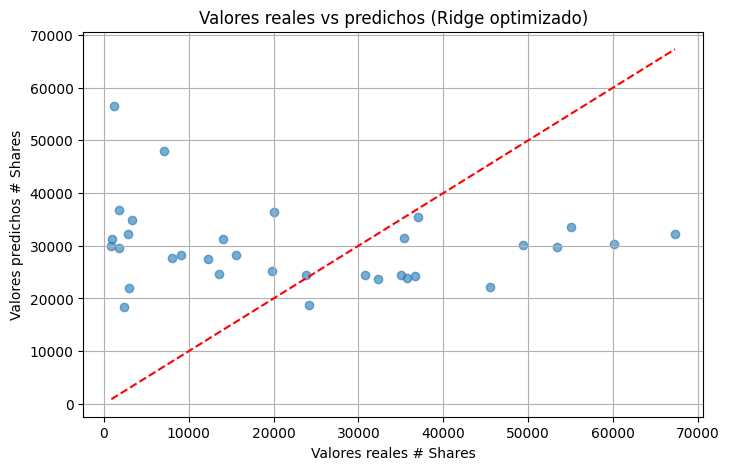

In [61]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_test_pred_best, alpha=0.6)

min_val = min(y_test.min(), y_test_pred_best.min())
max_val = max(y_test.max(), y_test_pred_best.max())

plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Valores reales # Shares")
plt.ylabel("Valores predichos # Shares")
plt.title("Valores reales vs predichos (Ridge optimizado)")
plt.grid(True)
plt.show()


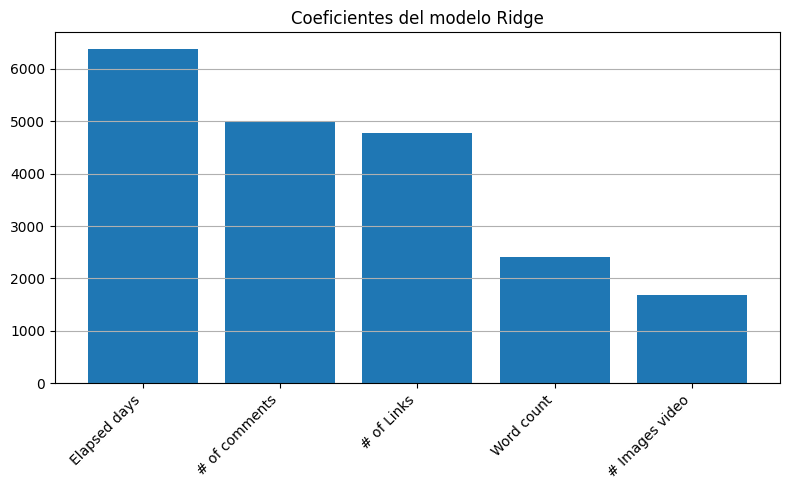

In [62]:
coefs = best_ridge.coef_
indices = np.argsort(np.abs(coefs))[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(feature_cols)), coefs[indices])
plt.xticks(
    range(len(feature_cols)),
    [feature_cols[i] for i in indices],
    rotation=45,
    ha='right'
)
plt.title("Coeficientes del modelo Ridge")
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


In [63]:
modelo_ridge = {
    "scaler": scaler,
    "model": best_ridge,
    "feature_cols": feature_cols
}

joblib.dump(modelo_ridge, "modelo_ridge_articulos.pkl")
print("Modelo guardado como 'modelo_ridge_articulos.pkl'")


Modelo guardado como 'modelo_ridge_articulos.pkl'
